# Simple LSTM baseline for predicting review scores

## Introduction
### Context
Bangalore is the capital and largest city of the Indian state of Karnataka. With a population of over 15 million, Bangalore is the third largest city in India and 27th largest city in the world.

Bangalore has a unique food culture. Restaurants from all over the world can be found here in Bangalore, with various kind of cuisines.With each day new restaurants adding up to the industry and the demand is increasing day by day so it is useful to get some interesting facts and figures about the restaurants.

![Zomato](https://www.sentinelassam.com/wp-content/uploads/2019/10/chennai-has-highest-zomato-female-delivery-partners-1280x720-e1570185357911.jpg)

### Problem
The basic idea of analyzing the Zomato dataset is to get a fair idea about the factors affecting the establishment of different types of the restaurant at different places in Bengaluru, aggregate rating of each restaurant, Bengaluru being one such city has more than 12,000 restaurants with restaurants serving dishes from all over the world. With each day new restaurants opening the industry hasn't been saturated yet and the demand is increasing day by day. Inspite of increasing demand it, however, has become difficult for new restaurants to compete with established restaurants. Most of them serving the same food. Bengaluru being an IT capital of India. Most of the people here are dependent mainly on the restaurant food as they don’t have time to cook for themselves.


### What is sentiment analysis?
Sentiment analysis is the computational task of automatically determining what feelings a writer is expressing in text. Sentiment is often framed as a binary distinction (positive vs. negative), but it can also be a more fine-grained, like identifying the specific emotion an author is expressing (like fear, joy or anger).

Sentiment analysis is used for many applications, especially in business intelligence. Some examples of applications for sentiment analysis include:

#### Analyzing the social media discussion around a certain topic
 - Evaluating survey responses
 - Determining whether product reviews are positive or negative
 - Sentiment analysis is not perfect, and as with any automatic analysis of language, you will have errors in your results. It also cannot tell you why a writer is feeling a certain way. However, it can be useful to quickly summarize some qualities of text, especially if you have so much text that a human reader cannot analyze all of it.

For this project,the goal is to analyzing the Zomato Bangalore dataset is to understand people’s choice of cuisine,dining type,preference for location according to price etc.


In this notebook, we will go through:

1. **Preprocessing** - Load the dataset, retrieve the reviews (aka documents) and scores, encode the target (scores) and split into a training and test set.
2. **Training Model** - We will train a simple LSTM model that will predict the rating based solely on the review comments.
3. **Evaluation** - We will plot the loss and accuracy progression through epochs, and display the classification results as a table.

In [ ]:
import json
import re

import numpy as np 
import pandas as pd
from keras.models import Model
from keras.layers import Input, Dense, Embedding, SpatialDropout1D, add, concatenate
from keras.layers import CuDNNLSTM, Bidirectional, GlobalMaxPooling1D, GlobalAveragePooling1D
from keras.callbacks import Callback, ModelCheckpoint
from keras.preprocessing import text, sequence
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [ ]:
tqdm.pandas()

# Preprocessing

## Loading data

In [ ]:
zomato_orgnl = pd.read_csv('../input/zomato-bangalore-restaurants/zomato.csv')

print(zomato_orgnl.shape)
zomato_orgnl.head()

(51717, 17)


,url,address,name,online_order,book_table,rate,votes,phone,location,rest_type,dish_liked,cuisines,approx_cost(for two people),reviews_list,menu_item,listed_in(type),listed_in(city)
0,https://www.zomato.com/bangalore/jalsa-banasha...,"942, 21st Main Road, 2nd Stage, Banashankari, ...",Jalsa,Yes,Yes,4.1/5,775,080 42297555\r\n+91 9743772233,Banashankari,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese",800,"[('Rated 4.0', 'RATED\n A beautiful place to ...",[],Buffet,Banashankari
1,https://www.zomato.com/bangalore/spice-elephan...,"2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...",Spice Elephant,Yes,No,4.1/5,787,080 41714161,Banashankari,Casual Dining,"Momos, Lunch Buffet, Chocolate Nirvana, Thai G...","Chinese, North Indian, Thai",800,"[('Rated 4.0', 'RATED\n Had been here for din...",[],Buffet,Banashankari
2,https://www.zomato.com/SanchurroBangalore?cont...,"1112, Next to KIMS Medical College, 17th Cross...",San Churro Cafe,Yes,No,3.8/5,918,+91 9663487993,Banashankari,"Cafe, Casual Dining","Churros, Cannelloni, Minestrone Soup, Hot Choc...","Cafe, Mexican, Italian",800,"[('Rated 3.0', ""RATED\n Ambience is not that ...",[],Buffet,Banashankari
3,https://www.zomato.com/bangalore/addhuri-udupi...,"1st Floor, Annakuteera, 3rd Stage, Banashankar...",Addhuri Udupi Bhojana,No,No,3.7/5,88,+91 9620009302,Banashankari,Quick Bites,Masala Dosa,"South Indian, North Indian",300,"[('Rated 4.0', ""RATED\n Great food and proper...",[],Buffet,Banashankari
4,https://www.zomato.com/bangalore/grand-village...,"10, 3rd Floor, Lakshmi Associates, Gandhi Baza...",Grand Village,No,No,3.8/5,166,+91 8026612447\r\n+91 9901210005,Basavanagudi,Casual Dining,"Panipuri, Gol Gappe","North Indian, Rajasthani",600,"[('Rated 4.0', 'RATED\n Very good restaurant ...",[],Buffet,Banashankari


In [ ]:
#Deleting Unnnecessary Columns
zomato=zomato_orgnl.drop(['url','dish_liked','phone'],axis=1) 

In [ ]:
#Removing the Duplicates
zomato.duplicated().sum()
zomato.drop_duplicates(inplace=True)

In [ ]:
#Remove the NaN values from the dataset
zomato.isnull().sum()
zomato.dropna(how='any',inplace=True)
zomato.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43499 entries, 0 to 51716
Data columns (total 14 columns):
address                        43499 non-null object
name                           43499 non-null object
online_order                   43499 non-null object
book_table                     43499 non-null object
rate                           43499 non-null object
votes                          43499 non-null int64
location                       43499 non-null object
rest_type                      43499 non-null object
cuisines                       43499 non-null object
approx_cost(for two people)    43499 non-null object
reviews_list                   43499 non-null object
menu_item                      43499 non-null object
listed_in(type)                43499 non-null object
listed_in(city)                43499 non-null object
dtypes: int64(1), object(13)
memory usage: 5.0+ MB


In [ ]:
#Changing the Columns Names
zomato.columns
zomato = zomato.rename(columns={'approx_cost(for two people)':'cost','listed_in(type)':'type',
                                  'listed_in(city)':'city'})
zomato.columns

Index(['address', 'name', 'online_order', 'book_table', 'rate', 'votes',
       'location', 'rest_type', 'cuisines', 'cost', 'reviews_list',
       'menu_item', 'type', 'city'],
      dtype='object')

In [ ]:
#Some Transformations
zomato['cost'] = zomato['cost'].astype(str)
zomato['cost'] = zomato['cost'].apply(lambda x: x.replace(',','.'))
zomato['cost'] = zomato['cost'].astype(float)
zomato.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43499 entries, 0 to 51716
Data columns (total 14 columns):
address         43499 non-null object
name            43499 non-null object
online_order    43499 non-null object
book_table      43499 non-null object
rate            43499 non-null object
votes           43499 non-null int64
location        43499 non-null object
rest_type       43499 non-null object
cuisines        43499 non-null object
cost            43499 non-null float64
reviews_list    43499 non-null object
menu_item       43499 non-null object
type            43499 non-null object
city            43499 non-null object
dtypes: float64(1), int64(1), object(12)
memory usage: 5.0+ MB


In [ ]:
#Removing '/5' from Rates
zomato['rate'].unique()
zomato = zomato.loc[zomato.rate !='NEW']
zomato = zomato.loc[zomato.rate !='-'].reset_index(drop=True)
remove_slash = lambda x: x.replace('/5', '') if type(x) == np.str else x
zomato.rate = zomato.rate.apply(remove_slash).str.strip().astype('float')
zomato['rate'].head()

0    4.1
1    4.1
2    3.8
3    3.7
4    3.8
Name: rate, dtype: float64

In [ ]:
df = zomato.copy()

## Retrieve the text data

In [ ]:
all_ratings = []

for ratings in tqdm(df['reviews_list']):
    ratings = eval(ratings)
    
    for score, doc in ratings:
        if score:
            score = score.strip("Rated").strip()
            doc = doc.strip('RATED').strip()
            
            score = float(score)
            all_ratings.append([score, doc])

100%|██████████| 41237/41237 [00:20<00:00, 2027.90it/s]


In [ ]:
ratings_df = pd.DataFrame(all_ratings, columns=['score', 'doc'])

print(ratings_df.shape)
ratings_df.head()

(1295849, 2)


,score,doc
0,4.0,A beautiful place to dine in.The interiors tak...
1,4.0,I was here for dinner with my family on a week...
2,2.0,Its a restaurant near to Banashankari BDA. Me ...
3,4.0,We went here on a weekend and one of us had th...
4,5.0,The best thing about the place is itÃÃÃÃ...


## Remove ratings inside text

Some of the reviews have ratings within it. We want to train a generic model to predict ratings with only text, so we want to hide this extra information so the model does not overfit on that.

"Unhide" the output of the next cell to view sample of the ratings that contain the character `"/"`.

In [ ]:
docs_with_ratings = []
for doc in ratings_df['doc'][:150]:
    if '/' in doc:
        print(doc)
        docs_with_ratings.append(doc)

Great food and pleasant ambience. Expensive but Coll place to chill and relax......

Service is really very very good and friendly staff...

Food : 5/5
Service : 5/5
Ambience :5/5
Overall :5/5
I was looking for a quite place to spend some time with family and as well wanted to try some new place. Since I was at Banashankari I thought of trying this place. The place had good rating and was part of Zomato gold. So I decided to try this place. It was a delite to see a very friendly staff and food we ordered was very tasty as well.

Food : 4/5
Ambience :3/5
Friendly staff : 4/5
Pocket friendly : 4/5

Will definitely visit again ??
Food: 8/10
Ambience:8/10
Staff:8/10
One of the good places to try north Indian food...but depends on ur taste buds. Not everyone will like all the items here. Specially when u r particular abt sweet and spicy food.
There's buffet available too.
We had ordered paneer uttar dakshin and paneer kurchan..was amazing. The Gobi hara pyaz and mix veg were average.
One of

In [ ]:
print(len(docs_with_ratings))

26


We will use Regex to find and replace all the occurences of ratings. 

Let's take a look at all the parts of documents that matches the pattern `[0-9.]*[0-9]/[0-9]*[0-9]`, which correspond to any rating that has double digits (e.g. 10/10), single digits (5/5) or single digits with a fraction (e.g. 9.5/10 or 3.5/5).

In [ ]:
for docs in docs_with_ratings:
    x = re.findall('[0-9.]*[0-9]/[0-9]*[0-9]', docs)
    print(x)

['5/5', '5/5', '5/5', '5/5']
['4/5', '3/5', '4/5', '4/5']
['8/10', '8/10', '8/10']
['6/10', '7/10', '8/10', '7.5/10']
[]
[]
[]
[]
['4/5', '3.5/5', '4/5', '4/5']
['3/5', '3/5', '3/5']
['10/10', '10/10', '10/10', '25/10']
['4/5', '10/5']
['4/5', '4/5', '4/5']
['4/5', '10/5']
['4/5', '4/5', '4/5']
['4/5', '10/5']
['4/5', '4/5', '4/5']
['4/5', '10/5']
['4/5', '4/5', '4/5']
['4/5', '10/5']
['4/5', '4/5', '4/5']
['4/5', '10/5']
['4/5', '4/5', '4/5']
['4.5/5', '4/5', '4.5/5', '4.5/5']
['3.5/5', '4/5', '3.5/5']
['3.5/5', '4/5', '3.5/5']


We will replace them with the word "score", since we do not want the model to overfit on ratings that are already given in the comments.

In [ ]:
doc = docs_with_ratings[0]
subbed_doc = re.sub('[0-9.]*[0-9]/[0-9]*[0-9]', 'score', doc)
print("ORIGINAL:")
print(doc)
print("\nSUBBED:")
print(subbed_doc)

ORIGINAL:
Great food and pleasant ambience. Expensive but Coll place to chill and relax......

Service is really very very good and friendly staff...

Food : 5/5
Service : 5/5
Ambience :5/5
Overall :5/5

SUBBED:
Great food and pleasant ambience. Expensive but Coll place to chill and relax......

Service is really very very good and friendly staff...

Food : score
Service : score
Ambience :score
Overall :score


Now, we do it for all texts.

In [ ]:
ratings_df.head()

,score,doc
0,4.0,A beautiful place to dine in.The interiors tak...
1,4.0,I was here for dinner with my family on a week...
2,2.0,Its a restaurant near to Banashankari BDA. Me ...
3,4.0,We went here on a weekend and one of us had th...
4,5.0,The best thing about the place is itÃÃÃÃ...


## Text Preprocessing

In [ ]:
ratings_df.head()

,score,doc
0,4.0,A beautiful place to dine in.The interiors tak...
1,4.0,I was here for dinner with my family on a week...
2,2.0,Its a restaurant near to Banashankari BDA. Me ...
3,4.0,We went here on a weekend and one of us had th...
4,5.0,The best thing about the place is itÃÃÃÃ...


In [ ]:
## Lower Casing
ratings_df['review'] = ratings_df['doc'].str.lower()

In [ ]:
import string
PUNCT_TO_REMOVE = string.punctuation
def remove_punctuation(text):
    """custom function to remove the punctuation"""
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

ratings_df['review'] = ratings_df['review'].apply(lambda text: remove_punctuation(text))

In [ ]:
ratings_df=ratings_df.drop(['doc'],axis=1) 

In [ ]:
## Removal of Stopwords
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))
def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

ratings_df['review'] = ratings_df['review'].apply(lambda text: remove_stopwords(text))
ratings_df.sample()

,score,review
503427,2.0,went place 3 years came friends long distance ...


In [ ]:
## Removal of urls
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

ratings_df['review'] = ratings_df['review'].apply(lambda text: remove_urls(text))
ratings_df.sample(3)

,score,review
1098351,1.0,ice cream melted
304066,4.0,time
1208647,5.0,pizzeria review taste iconic original neapolit...


## One Hot Encoding

Let's look at the distribution of ratings

In [ ]:
ratings_df['score'].astype('category').value_counts()

4.0    397337
5.0    372425
3.0    178102
1.0    149367
2.0     65870
3.5     55691
4.5     50292
2.5     17432
1.5      9333
Name: score, dtype: int64

Clearly this is categorical data, with some heavy class imbalance. This is something to address if you want to improve performance. We will go ahead and encode that into binary labels:

In [ ]:
dummies = pd.get_dummies(ratings_df['score'])
dummies.head()

,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0
0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,1,0,0
2,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,1


## Train Test Split

Finally, we split the data into train and test sets; the latter will be used to evaluate our model.

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(
    ratings_df['review'], 
    dummies, 
    test_size=0.1, random_state=19
)

# Building an LSTM Model

At this point, we are ready to build our model. Similar to the original kernel, we will go through the following steps:
1. Fit the Keras Tokenizer
2. Build an embedding matrix
3. Tokenize and pad our training data
4. Train the model

Once we are done training the model, we evaluate how well it performs. This part is covered in the next section.

## Helper functions to create fasttext embedding

In [ ]:
def build_matrix(word_index, path):
    def get_coefs(word, *arr):
        return word, np.asarray(arr, dtype='float32')

    def load_embeddings(path):
        with open(path) as f:
            embedding_index = {}
            
            for line in tqdm(f):
                word, arr = get_coefs(*line.strip().split(' '))    
                if word in word_index:
                    embedding_index[word] = arr
            
        return embedding_index

    embedding_index = load_embeddings(path)
    embedding_matrix = np.zeros((len(word_index) + 1, 300))
    
    for word, i in tqdm(word_index.items()):
        try:
            embedding_matrix[i] = embedding_index[word]
        except KeyError:
            pass
    return embedding_matrix

In [ ]:
def build_model(embedding_matrix):
    words = Input(shape=(None,))
    x = Embedding(*embedding_matrix.shape, weights=[embedding_matrix], trainable=False)(words)
    x = SpatialDropout1D(0.3)(x)
    x = Bidirectional(CuDNNLSTM(256, return_sequences=True))(x)

    hidden = concatenate([
        GlobalMaxPooling1D()(x),
        GlobalAveragePooling1D()(x),
    ])
    hidden = Dense(512, activation='relu')(hidden)
    result = Dense(9, activation='softmax')(hidden)
    
    model = Model(inputs=words, outputs=result)
    model.compile(
        loss='categorical_crossentropy', 
        optimizer='adam',
        metrics=['accuracy']
    )

    return model

## Creating the tokenizer

In [ ]:
%%time
CHARS_TO_REMOVE = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n“”’\'∞θ÷α•à−β∅³π‘₹´°£€\×™√²—'
tokenizer = text.Tokenizer(filters=CHARS_TO_REMOVE)
tokenizer.fit_on_texts(list(x_train) + list(x_test))

CPU times: user 1min 11s, sys: 22.9 ms, total: 1min 11s
Wall time: 1min 12s


In [ ]:
embedding_matrix = build_matrix(tokenizer.word_index, '../input/fasttext-crawl-300d-2m/crawl-300d-2M.vec')

2000001it [04:28, 7440.23it/s]
100%|██████████| 100933/100933 [00:00<00:00, 347972.21it/s]


In [ ]:
x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)
x_train = sequence.pad_sequences(x_train, maxlen=384)
x_test = sequence.pad_sequences(x_test, maxlen=384)

## Training

In [ ]:
model = build_model(embedding_matrix)
model.summary()

checkpoint = ModelCheckpoint(
    'model.h5', 
    monitor='val_acc', 
    verbose=1, 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto'
)

history = model.fit(
    x_train,
    y_train,
    batch_size=512,
    callbacks=[checkpoint],
    epochs=10,
    validation_split=0.1
)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 300)    30280200    input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, None, 300)    0           embedding_1[0][0]                
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, None, 512)    1142784     spatial_dropout1d_1[0][0]        
__________________________________________________________________________________________________
global_max

# Evaluation

## Training history

Let's take a look at how well the model is training.

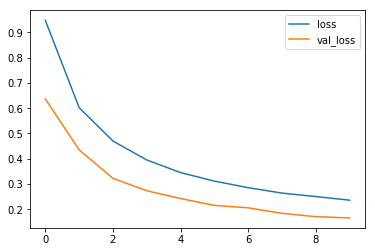

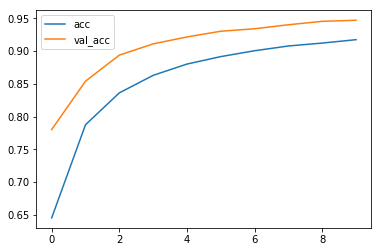

In [ ]:
with open('history.json', 'w') as f:
    json.dump(history.history, f)

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['acc', 'val_acc']].plot()

## End of the notebook